# examine initial conditions and aim to parameterize them

Note that the foremost aim here is to find a parameterization and estimate the initial conditions, at this point respiration rate etc. remain unconstrained

In [1]:
#%matplotlib notebook
import netCDF4 as nc4
import numpy as np

# load data
datafiles = {
    'seaflow':'data/SeaFlow_SizeDist_regrid-25-8.nc',    # m=25, delta_v_inv=8
    'zinser':'data/Zinser_SizeDist_calibrated-26-6.nc',  # m=26, delta_v_inv=3
}

desc = {
    'seaflow':'SeaFlow dataset',
    'zinser':'Zinser dataset',    
}

data_gridded = {}
for k in datafiles:
    data_gridded[k] = {}
    with nc4.Dataset(datafiles[k]) as nc:
        for var in nc.variables:
            data_gridded[k][var] = nc.variables[var][:]
    desc[k] += ' (m={data[m]}, $\Delta_v^{{-1}}$={data[delta_v_inv]})'.format(data=data_gridded[k])

data_gridded[k]['PAR'] *= 200.0/22.0 # make light similar for this experiment (it is later normalized by E_star) 

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def add_colorbar(ax, **cbarargs):
    axins_cbar = inset_axes(ax, width='3%', height='90%', loc=5, bbox_to_anchor=(0.05,0.0,1,1), bbox_transform=ax.transAxes)
    mpl.colorbar.ColorbarBase(axins_cbar, orientation='vertical', **cbarargs)

slice_indices = {}
for k in data_gridded:
    slice_indices[k] = np.flatnonzero(data_gridded[k]['time'] % 1440 <= 3)
    
for i,k in enumerate(data_gridded):
    nrows = 2
    fig,axs = plt.subplots(nrows=nrows, sharex=True, figsize=(12,4*nrows))

    ax = axs[0]
    ax.plot(data_gridded[k]['time'], data_gridded[k]['PAR'], color='gold')
    ax.set(ylabel='PAR')

    v_min = data_gridded[k]['v_min']
    delta_v = 1.0/data_gridded[k]['delta_v_inv']
    v = v_min * 2**(np.arange(data_gridded[k]['m'])*delta_v) 
    
    ax = axs[1]
    pc = ax.pcolormesh(data_gridded[k]['time'],v,data_gridded[k]['w_obs'])
    ax.set(ylabel='size ($\mu$m$^3$)')
    ax.text(0.01, 0.95, desc[k], color='white', size=16, transform=ax.transAxes, ha='left', va='top')
    add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')
    for i in slice_indices[k]:
        ax.axvline(data_gridded[k]['time'][i], color='.3')    

axs[-1].set_xlabel=('time (minutes)')

None

# Initial conditions (a look at the data + hand-selected log-normals)

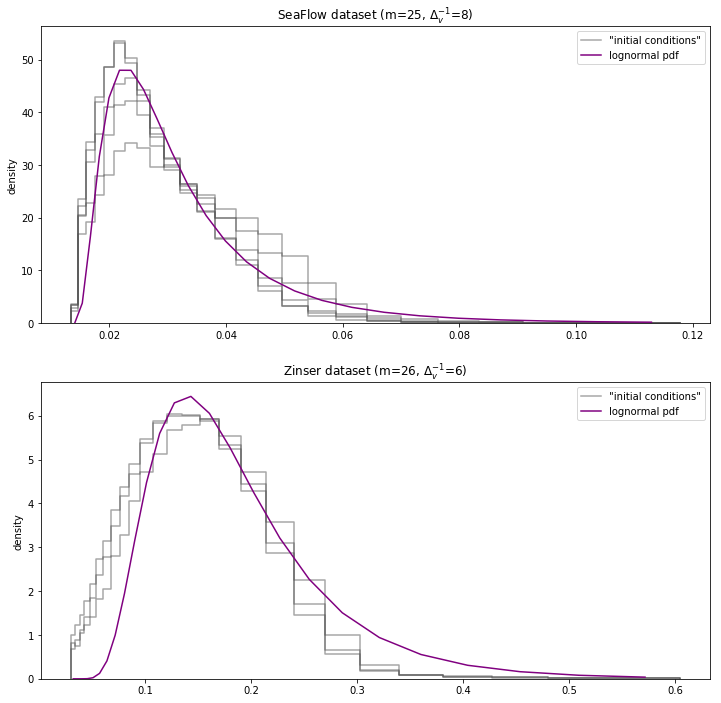

In [3]:
from scipy.stats import lognorm

lognorm_params = {
    'seaflow':{'mu':np.log(0.015), 'sigma':0.7},
    'zinser_old':{'mu':np.log(0.04), 'sigma':0.7},
    'zinser':{'mu':np.log(0.14), 'sigma':0.5},
}

fig,axs = plt.subplots(nrows=len(slice_indices), figsize=(12,len(slice_indices)*6))
for k,ax in zip(slice_indices,axs.flat):
    plotdata_y = np.zeros(2*(data_gridded[k]['m']+1))
    
    delta_v = 1.0/data_gridded[k]['delta_v_inv']
    v_ext = data_gridded[k]['v_min'] * 2**(np.arange(data_gridded[k]['m']+1)*delta_v)
    v = v_ext[:-1]
    v_width = v_ext[1:] - v_ext[:-1]
    
    v_mid = 0.5*(v_ext[1:]+v_ext[:-1])
    y_lognorm = lognorm.pdf(v_mid-data_gridded[k]['v_min'], s=lognorm_params[k]['sigma'], scale=np.exp(lognorm_params[k]['mu']))
    
    for i in slice_indices[k]:
        cdata = data_gridded[k]['w_obs'][:,i]
        plotdata_y[1:-1] = np.repeat(cdata/v_width,2)
        ax.plot(np.repeat(v_ext,2), plotdata_y, color='0.3', alpha=0.5, label='"initial conditions"')
    ax.plot(v_mid, y_lognorm, color='purple', label='lognormal pdf')
    ax.set_ylabel('density')
    ax.set_ylim(bottom=0.0)
    ax.set_title(desc[k])
    

    
for ax in axs:
    ax.legend()
None

## finding a decent prior

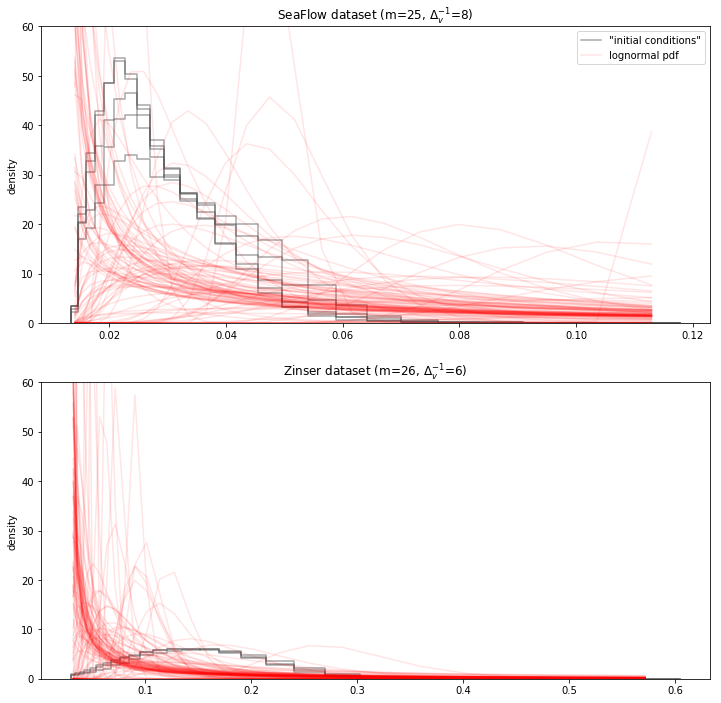

In [4]:
fig,axs = plt.subplots(nrows=len(slice_indices), figsize=(12,len(slice_indices)*6))
for k,ax in zip(slice_indices,axs.flat):
    plotdata_y = np.zeros(2*(data_gridded[k]['m']+1))
    
    delta_v = 1.0/data_gridded[k]['delta_v_inv']
    v_ext = data_gridded[k]['v_min'] * 2**(np.arange(data_gridded[k]['m']+1)*delta_v)
    v = v_ext[:-1]
    v_width = v_ext[1:] - v_ext[:-1]
    
    v_mid = 0.5*(v_ext[1:]+v_ext[:-1])
    x_lognorm = v_mid-data_gridded[k]['v_min']
    
    for i in slice_indices[k]:
        cdata = data_gridded[k]['w_obs'][:,i]
        plotdata_y[1:-1] = np.repeat(cdata/v_width,2)
        ax.plot(np.repeat(v_ext,2), plotdata_y, color='0.3', alpha=0.5, label='"initial conditions"')
    
    for isample in range(100):
        # the priors for mu and sigma (used for both datasets)
        sigma = np.random.uniform(low=0.03, high=3.0)
        mu = np.random.normal(loc=-3.0, scale=1.0)
        y_lognorm = np.exp(-(np.log(x_lognorm)-mu)**2/(2*sigma**2))/(x_lognorm*sigma*np.sqrt(2*np.pi)) 

        ax.plot(v_mid, y_lognorm, color='red', label='lognormal pdf', alpha=0.1)
    ax.set_ylabel('density')
    ax.set_ylim(bottom=0.0)
    ax.set_title(desc[k])

for ax in axs.flat:
    ax.set_ylim(top=60)
axs[0].legend()
None

# The model

modified from *Sosik et al. (2003), Growth rates of coastal phytoplankton from time-series measurements with a submersible flow cytometer, Limnol. Oceanogr.*

In [5]:
# prepare data for Stan model

data = {}

for k in data_gridded:
    dt = 20 # in units of minutes
    
    data[k] = {'dt':dt}
    for v in ('m','v_min','delta_v_inv'):
        data[k][v] = data_gridded[k][v]

    data[k]['obs'] = data_gridded[k]['w_obs']
    data[k]['t_obs'] = data_gridded[k]['time']
    data[k]['E'] = data_gridded[k]['PAR']
    # use first measurements as initial conditions
    data[k]['w_ini'] = data_gridded[k]['w_obs'][:,0]

    # limit the data

    limit_days = 2
    if 'seaflow' in k:
        stride_t_obs = 20
    else:
        stride_t_obs = 1

    # remove very first observations
    ind_obs = data[k]['t_obs'] > 3
    data[k]['t_obs'] = data[k]['t_obs'][ind_obs]
    data[k]['obs'] = data[k]['obs'][:,ind_obs]

    if limit_days > 0:
        limit_minutes = limit_days*1440

        ind_obs = data[k]['t_obs'] < limit_minutes
        data[k]['t_obs'] = data[k]['t_obs'][ind_obs]
        data[k]['obs'] = data[k]['obs'][:,ind_obs]

        data[k]['nt'] = int(limit_minutes//data[k]['dt'])

    if stride_t_obs > 0:
        data[k]['t_obs'] = data[k]['t_obs'][::stride_t_obs]
        data[k]['obs'] = data[k]['obs'][:,::stride_t_obs]

    data[k]['nt_obs'] = data[k]['obs'].shape[1]

    # finally, add light data
    t = np.arange(data[k]['nt'])*data[k]['dt']
    data[k]['E'] = np.interp(t, xp=data_gridded[k]['time'], fp=data_gridded[k]['PAR'])

In [6]:
import pystan

modelfiles = {
    #'freedelta':'stancode/matrixmodel_freedelta_normparam_trackgrowth.stan',
    #'onedelta_lightthresh':'stancode/matrixmodel_onedelta-lightthresh_normparam_trackgrowth.stan',
    #'freedelta_lightthresh':'stancode/matrixmodel_freedelta-lightthresh_normparam_trackgrowth.stan',
    'freedelta_gammai':'stancode/matrixmodel_estinilnorm_freedelta_gammai_normparam_trackgrowth.stan',
    #'freedelta_lightthresh_gammai':'stancode/matrixmodel_freedelta-lightthresh_gammai_normparam_trackgrowth.stan',
    #'sigdelta_gammai':'stancode/matrixmodel_sigmoidaldelta_gammai_normparam_trackgrowth.stan',
}
desc_model = {
    'freedelta':'model with "free" deltas',
    'onedelta_lightthresh':'model with one delta (no size-dep), light threshold for division',
    'freedelta_lightthresh':'model with "free" deltas, light threshold for division',
    'freedelta_gammai':'model with "free" deltas, size-dependent growth',
    'freedelta_lightthresh_gammai':'model with "free" deltas, light threshold for division, size-dependent growth',
    'sigdelta_gammai':'model with sigmoidal delta, size-dependent growth',
}

models = {name:pystan.StanModel(file=modelfiles[name], model_name=name, obfuscate_model_name=False) for name in modelfiles}

INFO:pystan:COMPILING THE C++ CODE FOR MODEL freedelta_gammai NOW.


In [7]:
# run a bunch of experiments -- this may take a while

mcmcs = {}
for name in models:
    mcmcs[name] = {}
    for k in data:
        mcmcs[name][k] = models[name].sampling(data=data[k], iter=2000)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [8]:
for name in models:
    for k in data:
        print('model: "{}", {}'.format(name, desc[k].split('(')[0]))
        print('\n'.join(x for x in mcmcs[name][k].__str__().split('\n') if 'mod_obspos' not in x))

model: "freedelta_gammai", SeaFlow dataset 
Inference for Stan model: freedelta_gammai.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean      sd    2.5%     25%     50%    75%   97.5%  n_eff   Rhat
delta_mu             3.33    0.02    0.63    2.22    2.88    3.28   3.73    4.66   1413    1.0
delta_sigma          2.07    0.02    0.72    1.01    1.56    1.94   2.46    3.78   1122    1.0
delta_max[1]          0.3  3.3e-3    0.15    0.08    0.19    0.28   0.39    0.65   2127    1.0
delta_max[2]         0.99  3.8e-3     0.2    0.68    0.85    0.97   1.11    1.43   2719    1.0
delta_max[3]         1.46  4.6e-3    0.24    1.01     1.3    1.45   1.61    1.96   2731    1.0
delta_max[4]         2.05  7.0e-3    0.37    1.35    1.79    2.04    2.3    2.81   2851    1.0
delta_max[5]          2.6  8.7e-3    0.51    1.65    2.24     2.6   2.94    3.67   3499    1.0
delta_max[6]         3.25    0.01 

## Plot the results

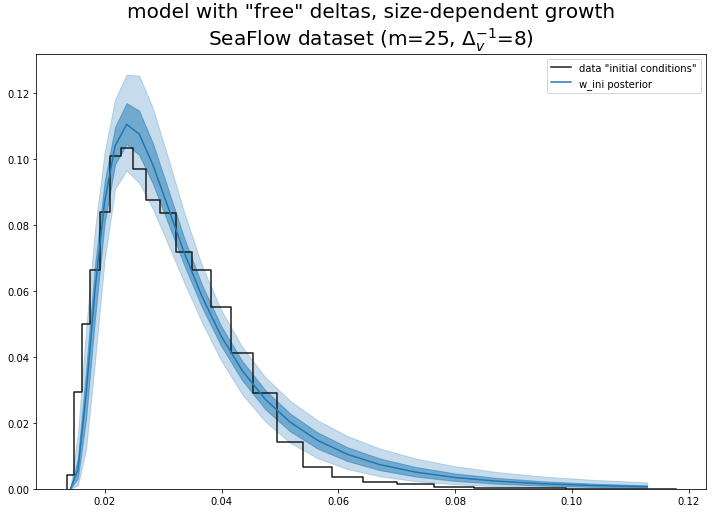

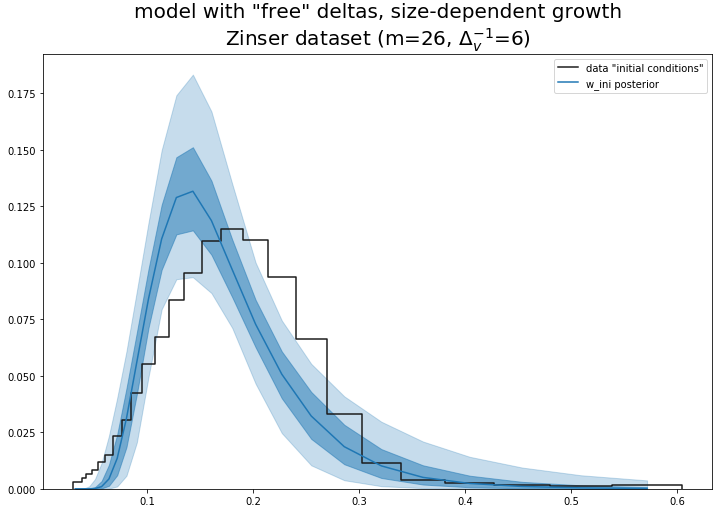

In [9]:
for name,mcmc in mcmcs.items():
    for k in data:
        fig, ax = plt.subplots(figsize=(12,8))
        ax.set_title(desc_model[name] + '\n' + desc[k], size=20)
        
        plotdata_y = np.zeros(2*(data_gridded[k]['m']+1))

        delta_v = 1.0/data_gridded[k]['delta_v_inv']
        v_ext = data_gridded[k]['v_min'] * 2**(np.arange(data_gridded[k]['m']+1)*delta_v)
        v = v_ext[:-1]
        v_width = v_ext[1:] - v_ext[:-1]

        v_mid = 0.5*(v_ext[1:]+v_ext[:-1])
        
        cdata = data_gridded[k]['w_obs'][:,0]
        plotdata_y[1:-1] = np.repeat(cdata,2)
        
        ax.plot(np.repeat(v_ext,2), plotdata_y, color='0.1', label='data "initial conditions"')
        
        quantiles = np.percentile(mcmc[k]['w_ini'], (5,25,50,75,95), axis=0)
        
        ax.fill_between(v_mid, quantiles[0,:], quantiles[-1,:], color='C0', alpha=0.25)
        ax.fill_between(v_mid, quantiles[1,:], quantiles[-2,:], color='C0', alpha=0.5)
        ax.plot(v_mid, quantiles[2,:], color='C0', label='w_ini posterior')
        
        ax.set_ylim(bottom=0.0)
        ax.legend()
None

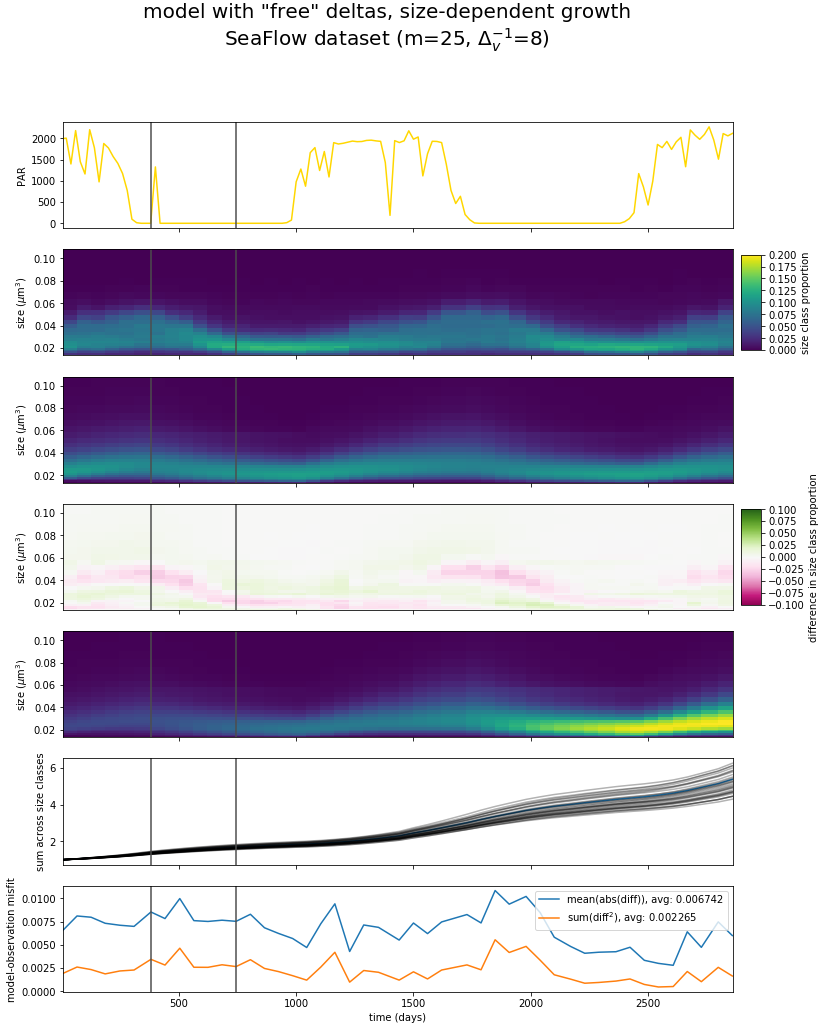

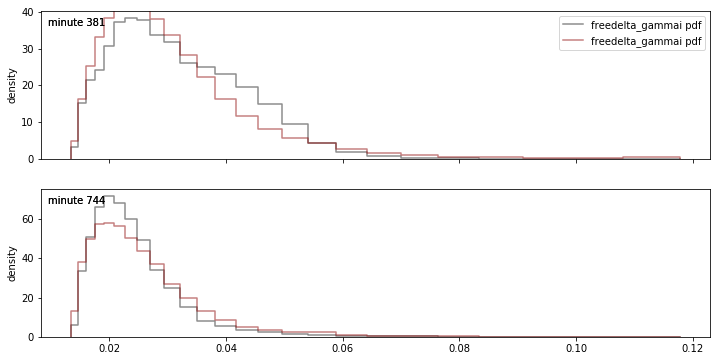

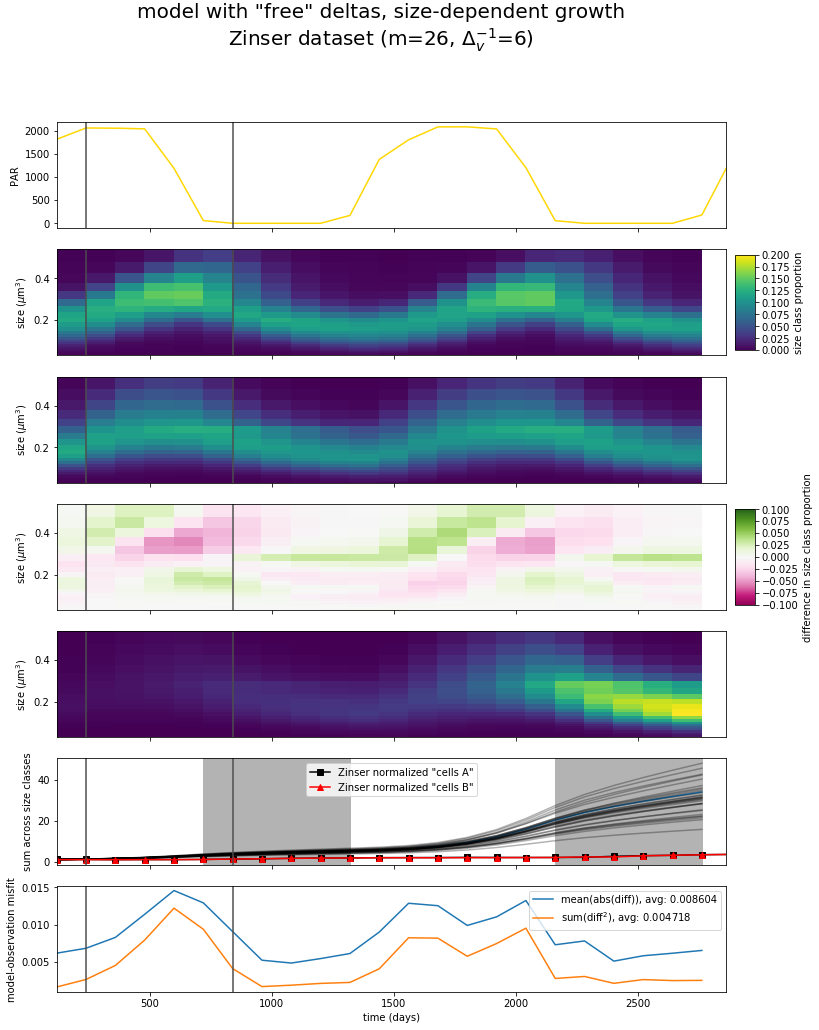

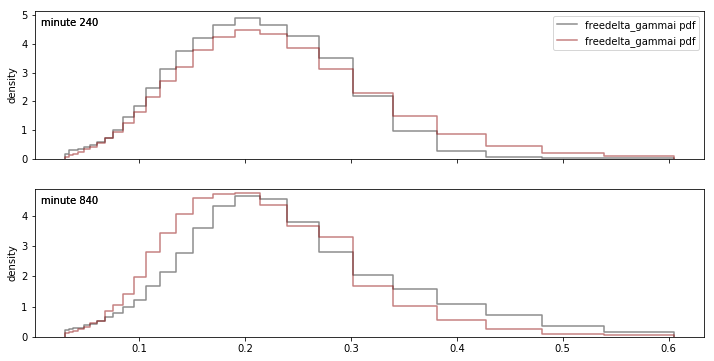

In [10]:
import pandas

data_fig2a = pandas.read_csv('data/Zinser_Figure2A.csv')

t_zinser = data_fig2a['exper time'] * 60
a_norm = data_fig2a['cells A'].copy()
a_norm /= a_norm[0]
b_norm = data_fig2a['cells B'].copy()
b_norm /= b_norm[0]

colors = {'model':'darkred', 'obs':'0.1'}

norm = mpl.colors.Normalize(0.0,0.2)
norm_diff = mpl.colors.Normalize(-0.1,0.1)

for name,mcmc in mcmcs.items():
    for k in data:
        t = data[k]['dt']*np.arange(data[k]['nt'])
        if 'zinser' in k:
            slice_indices = [1,6]
        else:
            slice_indices = [6,12]
        delta_v = 1.0/data_gridded[k]['delta_v_inv']
        v_ext = data[k]['v_min'] * 2**(np.arange(data[k]['m']+1)*delta_v) 
        v = v_ext[:-1]
        v_width = v_ext[1:] - v_ext[:-1]
        
        res = {'model':np.mean(mcmc[k]['mod_obspos'], axis=0), 'obs':data[k]['obs']}
        res_sum1 = res['model']/np.sum(res['model'], axis=0)[None,:]
        diff = res_sum1-res['obs']

        fig,axs = plt.subplots(7,1,sharex=True,figsize=(12,16))
        fig.suptitle(desc_model[name] + '\n' + desc[k], size=20)

        ax = axs[0]
        ax.plot(t, data[k]['E'], color='gold')
        ax.set(xlim=(data[k]['t_obs'][0],t[-1]), ylabel='PAR')

        ax = axs[1]
        pc = ax.pcolormesh(data[k]['t_obs'],v,res['obs'],norm=norm)
        ax.set(ylabel='size ($\mu$m$^3$)')
        add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')

        ax = axs[2]
        ax.set(ylabel='size ($\mu$m$^3$)')
        pc = ax.pcolormesh(data[k]['t_obs'],v,res_sum1,norm=norm)

        ax = axs[3]
        pc = ax.pcolormesh(data[k]['t_obs'],v,diff,norm=norm_diff, cmap='PiYG')
        ax.set(ylabel='size ($\mu$m$^3$)')
        add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='difference in size class proportion')

        ax = axs[4]
        ax.set(ylabel='size ($\mu$m$^3$)')
        pc = ax.pcolormesh(data[k]['t_obs'],v,res['model'])

        ax = axs[5]
        ax.plot(data[k]['t_obs'], np.sum(res['model'],axis=0))
        ax.plot(data[k]['t_obs'], np.sum(mcmc[k]['mod_obspos'][:30,...], axis=1).T, color='k', alpha=0.3)
        if 'zinser' in k:
            ax.plot(t_zinser, a_norm, color='black', marker='s', label='Zinser normalized "cells A"')
            ax.plot(t_zinser, b_norm, color='red', marker='^', label='Zinser normalized "cells B"')
            for iday in range(2):
                ax.axvspan(iday*24*60+12*60, iday*24*60+22*60, color='0.7', zorder=0)
            ax.legend()
        ax.set(ylabel='sum across size classes')

        ax = axs[6]
        prop = np.mean(np.abs(diff),axis=0)
        ax.plot(data[k]['t_obs'], prop, label='mean(abs(diff)), avg: {:.6f}'.format(np.mean(prop)))
        prop = np.sum(diff**2,axis=0)
        ax.plot(data[k]['t_obs'], prop, label='sum(diff$^2$), avg: {:.6f}'.format(np.mean(prop)))
        ax.set(xlabel='time (days)', ylabel='model-observation misfit')
        ax.legend()

        for ax in axs.flat:
            for i in slice_indices:
                ax.axvline(data[k]['t_obs'][i], color='.3')

        # plot slices

        plotdata_y = np.zeros(2*(data[k]['m']+1))

        fig,axs = plt.subplots(nrows=len(slice_indices), sharex=True, figsize=(12,len(slice_indices)*3))
        for i,ax in zip(slice_indices,axs.flat):
            for key in ('obs','model'):
                color = colors[key]
                cdata = res[key][:,i]
                cdata /= sum(cdata)
                plotdata_y[1:-1] = np.repeat(cdata/v_width,2)
                ax.plot(np.repeat(v_ext,2), plotdata_y, color=color, alpha=0.5, label='{} pdf'.format(name))
                ax.text(0.01, 0.95, 'minute {}'.format(data[k]['t_obs'][i]), transform=ax.transAxes, va='top', ha='left')
                ax.set_ylabel('density')
                ax.set_ylim(bottom=0.0)
        axs[0].legend()
        None

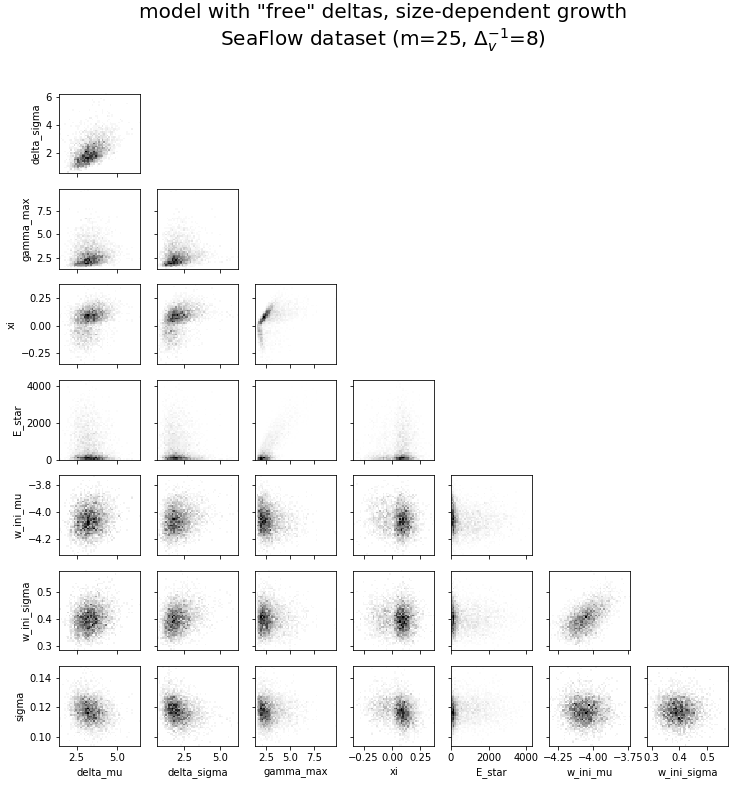

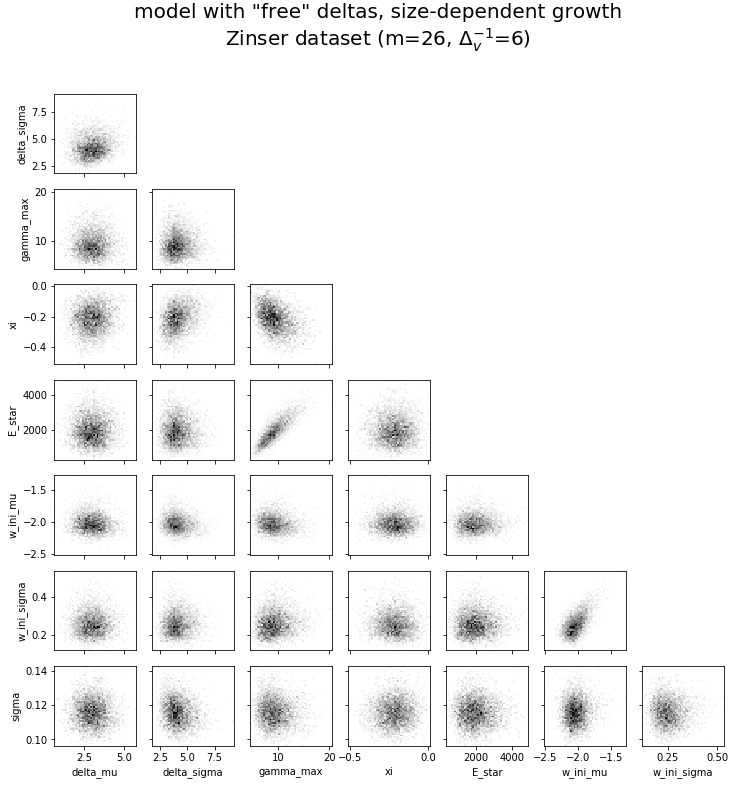

In [11]:
for name,mcmc in mcmcs.items():
    for k in data:
        paramnames = [v for v in mcmc[k].flatnames if not v.startswith('mod_obspos') and not v.startswith('delta_max') and not v.startswith('w_ini[')]
        num_params = len(paramnames)

        fig,axs = plt.subplots(num_params-1,num_params-1,sharex='col',sharey='row',figsize=(12,12), squeeze=False)
        fig.suptitle(desc_model[name] + '\n' + desc[k], size=20)
        for ax in axs.flat:
            ax.set_visible(False)
        for irow in range(1,num_params):
            for icol in range(irow):
                ax = axs[irow-1,icol]
                ax.set_visible(True)
                xname = paramnames[icol]
                yname = paramnames[irow]
                ax.hist2d(mcmc[k][xname],mcmc[k][yname],bins=50,cmap=mpl.cm.gray_r)
                if icol == 0:
                    ax.set_ylabel(yname)
                if irow == num_params-1:
                    ax.set_xlabel(xname)